
# Case Study 5: Bayesian Neural Network

Adapted from https://num.pyro.ai/en/stable/examples/bnn.html , we first see the NumPyro implementation and then SOGA.


In [1]:
from sogaPreprocessor import *
from producecfg import *
from libSOGA import *
from time import time

torch.set_default_dtype(torch.float64)

### Training the BNN with HMC in Pyro

In [2]:
import time

import matplotlib
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn.functional as F
from torch.distributions import constraints

import pyro
import pyro.distributions as dist
from pyro.infer import MCMC, NUTS, Predictive
torch.set_default_dtype(torch.float64)



# the non-linearity we use in our neural network
def nonlin(x):
    return F.relu(x)


def model(X, Y, D_H, D_Y=1):
    D_X = 1
    N = X.shape[0]

    # Sample first layer weights and biases
    w1 = pyro.sample("w1", dist.Normal(torch.zeros(D_X, D_H, dtype=torch.float32), torch.ones(D_X, D_H, dtype=torch.float32)))
    b1 = pyro.sample("b1", dist.Normal(torch.zeros(D_H, dtype=torch.float32), torch.ones(D_H, dtype=torch.float32)))
    z1 = nonlin(torch.matmul(X, w1) + b1)  # First layer activations
    #print('X', X.shape, 'w1', w1.shape, 'b1', b1.shape, 'z1', z1.shape)

    # Sample second layer weights and biases
    #w2 = pyro.sample("w2", dist.Normal(torch.zeros(D_H, D_H, dtype=torch.float32), torch.ones(D_H, D_H, dtype=torch.float32)))
    #b2 = pyro.sample("b2", dist.Normal(torch.zeros(D_H, dtype=torch.float32), torch.ones(D_H, dtype=torch.float32)))
    #z2 = nonlin(torch.matmul(z1, w2) + b2)  # Second layer activations

    # Sample final layer weights and biases
    w3 = pyro.sample("w3", dist.Normal(torch.zeros(D_H, D_Y, dtype=torch.float32), torch.ones(D_H, D_Y, dtype=torch.float32)))
    b3 = pyro.sample("b3", dist.Normal(torch.zeros(D_Y, dtype=torch.float32), torch.ones(D_Y, dtype=torch.float32)))
    z3 = torch.matmul(z1, w3) + b3  # Final output of the neural network
    #print('w3', w3.shape, 'b3', b3.shape, 'z3', z3.shape)

    # Observation noise (fixed for simplicity)
    sigma_obs = torch.tensor(0.1, dtype=torch.float32)

    # Observe data
    pyro.sample("Y", dist.Normal(z3.squeeze(1), sigma_obs), obs=Y)


# helper function for HMC inference
def run_inference(model, X, Y, D_H):
    start = time.time()
    kernel = NUTS(model)
    mcmc = MCMC(
        kernel,
        num_samples=2000,
        warmup_steps=500,
        num_chains=1,
    )
    mcmc.run(X, Y, D_H)
    mcmc.summary()
    print("\nMCMC elapsed time:", time.time() - start)
    return mcmc.get_samples()


# helper function for prediction
def predict(model, samples, X, D_H):
    predictive = Predictive(model, samples)
    predictions = predictive(X, None, D_H)["Y"]
    return predictions


# create artificial regression dataset
# Ensure all tensors are of dtype torch.float32
def get_data(N=20, D_X=3, sigma_obs=0.05, N_test=50):
    D_Y = 1  # create 1d outputs
    np.random.seed(0)
    X = np.linspace(-1, 1, N)
    X = np.power(X[:, np.newaxis], np.arange(D_X))
    W = 0.5 * np.random.randn(D_X)
    Y = np.dot(X, W) + 0.5 * np.power(0.5 + X[:, 1], 2.0) * np.sin(4.0 * X[:, 1])
    Y += sigma_obs * np.random.randn(N)
    Y = Y[:, np.newaxis]
    Y -= np.mean(Y)
    Y /= np.std(Y)

    assert X.shape == (N, D_X)
    assert Y.shape == (N, D_Y)

    X_test = np.linspace(-1.3, 1.3, N_test)
    X_test = np.power(X_test[:, np.newaxis], np.arange(D_X))

    # Convert all tensors to float32
    return (
        torch.tensor(X[:, 1:2], dtype=torch.float32),
        torch.tensor(Y, dtype=torch.float32),
        torch.tensor(X_test[:, 1:2], dtype=torch.float32),
    )

args = [10, 2, 2]
N, D_X, D_H = args
X, Y, X_test = get_data(N=N, D_X=D_X)
Y = Y.squeeze()
#X = X.squeeze()
X_test = X_test.squeeze()
# do inference
samples = run_inference(model, X, Y, D_H)



Sample: 100%|██████████| 2500/2500 [05:32,  7.53it/s, step size=2.20e-02, acc. prob=0.903]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
     b1[0]     -2.17      0.29     -2.16     -2.64     -1.69    416.22      1.00
     b1[1]      0.88      0.34      0.83      0.37      1.40    503.53      1.00
     b3[0]      1.41      0.21      1.37      1.12      1.66    333.51      1.00
   w1[0,0]      3.12      0.41      3.11      2.46      3.80    434.07      1.00
   w1[0,1]     -1.24      0.45     -1.16     -1.93     -0.56    521.54      1.00
   w3[0,0]     -3.66      0.49     -3.63     -4.52     -2.95    526.44      1.00
   w3[1,0]     -1.18      0.44     -1.09     -1.79     -0.50    512.23      1.00

Number of divergences: 0

MCMC elapsed time: 332.3700830936432


In [3]:
# predict Y_test at inputs X_test
predictions = predict(model, samples, X, D_H)

# compute mean prediction and confidence interval around median
mean_prediction = predictions.mean(0).detach().numpy()
percentiles = np.percentile(predictions.detach().numpy(), [5.0, 95.0], axis=0)

In [4]:
print(predictions.mean(0))
print(Y)

tensor([-0.7920, -0.5123, -0.2247,  0.0576,  0.3432,  0.6241,  0.9094,  1.1893,
         0.4243, -2.0417], dtype=torch.float32)
tensor([-0.3339, -0.2940, -0.2069, -0.5793, -0.1670,  0.1788,  1.2079,  1.8025,
         0.4927, -2.1008], dtype=torch.float32)


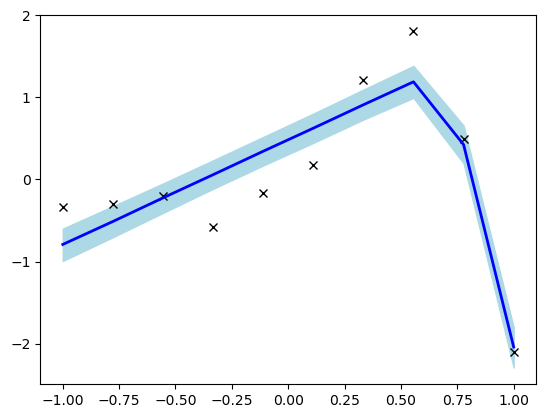

In [5]:
# make plots
#fig, ax = plt.subplots(figsize=(8, 6))

# plot training data
plt.plot(X.numpy(), Y.numpy(), "kx")
# plot 90% confidence level of predictions
plt.fill_between(
    X.numpy().flatten(), percentiles[0, :], percentiles[1, :], color="lightblue"
)
# plot mean prediction
plt.plot(X.numpy().flatten(), mean_prediction, "blue", ls="solid", lw=2.0)
#ax.set(xlabel="X", ylabel="Y", title="Mean predictions with 90% CI")

#plt.savefig("bnn_plot_pyro.pdf")
plt.show()

In [6]:
def predict_by_sample(X, D_X=1, D_H=2, D_Y=1):

    N = X.shape[0]  # Number of data points

    # Sample weights and biases from their distributions
    b1 = norm(loc=b1_mean, scale=b1_std).rvs(size=(D_H,))
    b3 = norm(loc=b3_mean, scale=b3_std).rvs(size=(D_Y,))
    w1 = norm(loc=w1_mean, scale=w1_std).rvs(size=(D_X, D_H))
    w3 = norm(loc=w3_mean, scale=w3_std).rvs(size=(D_H, D_Y))

    # Convert to torch tensors for matrix operations
    b1 = torch.tensor(b1, dtype=torch.float32)
    b3 = torch.tensor(b3, dtype=torch.float32)
    w1 = torch.tensor(w1, dtype=torch.float32)
    w3 = torch.tensor(w3, dtype=torch.float32)

    # Compute hidden layer activations
    z1 = F.relu(torch.matmul(X, w1) + b1)

    # Compute final output
    Y = torch.matmul(z1, w3) + b3

    return Y.detach().numpy()


In [7]:
X.numpy().shape

(10, 1)

In [8]:
Y_samples.shape


NameError: name 'Y_samples' is not defined

C:\Users\birik\AppData\Local\Temp\ipykernel_11388\4115577785.py:22: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Y[i] = w3 * h1 + w4 * h2 + b3
C:\Users\birik\AppData\Local\Temp\ipykernel_11388\4115577785.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mcmc_pars[key] = torch.tensor(value, requires_grad=True)


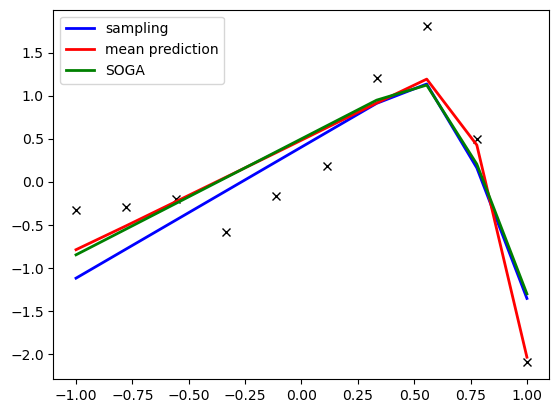

In [ ]:
from scipy.stats import norm

# Trying to replicate Pyro results

def predict_by_sample(X):

    Y = np.zeros(len(X))

    b1 = norm(loc=b1_mean, scale=b1_std).rvs()
    b2 = norm(loc=b2_mean, scale=b2_std).rvs()
    b3 = norm(loc=b3_mean, scale=b3_std).rvs()
    
    w1 = norm(loc=w1_mean, scale=w1_std).rvs()
    w2 = norm(loc=w2_mean, scale=w2_std).rvs()
    w3 = norm(loc=w3_mean, scale=w3_std).rvs()
    w4 = norm(loc=w4_mean, scale=w4_std).rvs()
    

    for i in range(10):
        h1 = max(w1 * X[i] + b1, 0)
        h2 = max(w2 * X[i] + b2, 0)
        Y[i] = w3 * h1 + w4 * h2 + b3

    return Y, np.array([b1, b2, b3, w1, w2, w3, w4])

def sample_predictions(X, n_samples=1000):
    
    Y_samples = []
    pars_samples = []

    for _ in range(n_samples):
        Y, pars = predict_by_sample(X)
        Y_samples.append(Y)
        pars_samples.append(pars)

    return np.array(Y_samples), np.array(pars_samples)

#print('Result for x', sample_predictions(x, n_samples=1000))

Y_samples, pars = sample_predictions(X.numpy(), n_samples=1000)

Y_samples_mean = np.mean(Y_samples, axis=0)


# With SOGA

compiledFile=compile2SOGA('../programs/SOGA/Optimization/Case Studies/bnn3.soga')
cfg = produce_cfg(compiledFile)
smooth_cfg(cfg)

mcmc_pars = {'muw1':w1_mean, 'muw2': w2_mean, 'muw3': w3_mean, 'muw4': w4_mean, 'mub1': b1_mean, 'mub2': b2_mean, 'mub3': b3_mean,
             'sigmaw1': w1_std, 'sigmaw2': w2_std, 'sigmaw3': w3_std, 'sigmaw4': w4_std, 'sigmab1': b1_std, 'sigmab2': b2_std, 'sigmab3': b3_std}

for key, value in mcmc_pars.items():
    mcmc_pars[key] = torch.tensor(value, requires_grad=True)    

output_dist = start_SOGA(cfg, mcmc_pars, pruning='ranking') #params_dict 


plt.plot(X.numpy(), Y.numpy(), "kx")
plt.plot(X.numpy(), Y_samples_mean, "blue", ls="solid", lw=2.0, label='sampling')
plt.plot(X.numpy().flatten(), mean_prediction, "red", ls="solid", lw=2.0, label='mean prediction')
plt.plot(X.numpy().flatten(), output_dist.gm.mean()[:10].detach().numpy(), "green", ls="solid", lw=2.0, label='SOGA')

plt.legend()



### SOGA Optimization

In [ ]:
def optimize(params_dict, loss_function, y, cfg, steps=500, lr=0.01):
    optimizer = torch.optim.Adam([params_dict[key] for key in params_dict.keys()], lr)

    total_start = time.time()

    for i in range(steps):

        optimizer.zero_grad()  # Reset gradients
        
        # loss
        current_dist = start_SOGA(cfg, params_dict, pruning='ranking')

        loss = loss_function(y, current_dist)

        # Backpropagate
        loss.backward(retain_graph=True)
        
        optimizer.step()

        # Print progress
        if i % int(steps/10) == 0:
            out = ''
            for key in params_dict.keys():
                out = out + key + ': ' + str(params_dict[key].item()) + ' '
            out = out + f" loss: {loss.item()}"
            print(out)

    total_end = time.time()

    print('Optimization performed in ', round(total_end-total_start, 3))

In [ ]:
def mean_squared_error(y_true, dist):
    return torch.mean((y_true - dist.gm.mean()) ** 2)

def mean_squared_error_bayes(y_true, dist):
    #This works for the means but of course not for the variances
    return torch.mean((y_true - dist.gm.mean()[:-2]) ** 2)

def neg_log_likelihood(y_true, dist):
    #Calculate the log-likelihood of the data given the distribution
    neg_log_likelihood = 0
    idx = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
    neg_log_likelihood = -torch.sum(torch.log(dist.gm.marg_pdf(y_true, idx)))
    return neg_log_likelihood

In [ ]:
neg_log_likelihood(Y.unsqueeze(0), output_dist_init)

tensor(36620.3906, grad_fn=<NegBackward0>)

loss: tensor(36620.3906, grad_fn=<NegBackward0>)


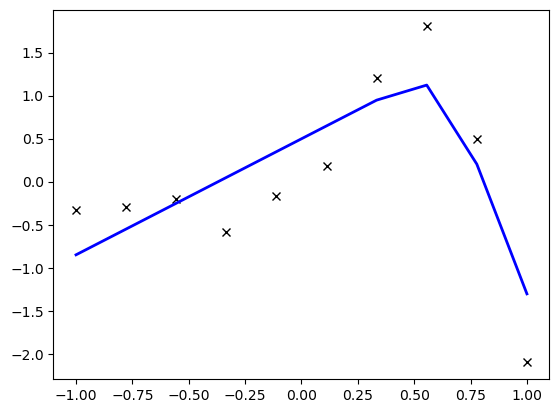

In [ ]:
# What happens if we use the parameters found by MCMC in SOGA?

from smoothcfg import *

compiledFile=compile2SOGA('../programs/SOGA/Optimization/Case Studies/bnn3_mean_only.soga')
cfg = produce_cfg(compiledFile)
smooth_cfg(cfg)

mcmc_pars_init = {'muw1': 0.0, 'muw2': 0.0, 'muw3': 0.0, 'muw4': 0.0, 'mub1': 0.0, 'mub2': 0.0, 'mub3': 0.0}

for key, value in mcmc_pars_init.items():
    mcmc_pars_init[key] = torch.tensor(value, requires_grad=True)    

output_dist_init = start_SOGA(cfg, mcmc_pars_init, pruning='ranking') #params_dict 

print('loss:', neg_log_likelihood(Y.unsqueeze(0), output_dist_init))

plt.plot(X.numpy(), Y.numpy(), "kx")
plt.plot(X.numpy().flatten(), output_dist.gm.mean()[:10].detach().numpy(), "blue", ls="solid", lw=2.0)


In [ ]:
compiledFile=compile2SOGA('../programs/SOGA/Optimization/Case Studies/bnn3_mean_onl.soga')
cfg = produce_cfg(compiledFile)

#let's optimize only the means
pars = {'muw1':0., 'muw2':0.,'muw3':0.,'muw4':0.,'mub1':0.,'mub2':0.,'mub3':0.}

for key, value in mcmc_pars.items():
    pars[key] = torch.tensor(value, requires_grad=True)    

output_dist = start_SOGA(cfg, pars, pruning='ranking') #params_dict 

#optimize(pars, neg_log_likelihood, Y.unsqueeze(1), cfg, steps=1000, lr = 0.01)

#predictive mean
#y_pred = params_dict['muw'].detach().numpy()*X.detach().numpy()+params_dict['mub'].detach().numpy()

#predictive variance
#sigma_y_pred = np.sqrt(params_dict['sigmay'].detach().numpy()**2 + (X.detach().numpy()*params_dict['sigmaw'].detach().numpy())**2 + params_dict['sigmab'].detach().numpy()**2)



In [ ]:
output_dist = start_SOGA(cfg, pars, pruning='ranking')

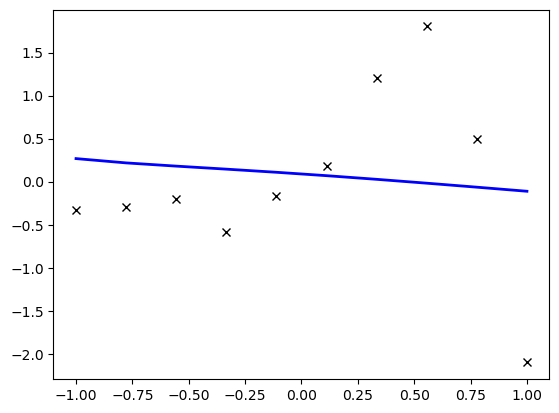

In [ ]:
# plot training data
plt.plot(X.numpy(), Y.numpy(), "kx")
# plot 90% confidence level of predictions
#plt.fill_between(X.numpy().flatten(), percentiles[0, :], percentiles[1, :], color="lightblue")
# plot mean prediction
plt.plot(X.numpy().flatten(), output_dist.gm.mean()[:10].detach().numpy(), "blue", ls="solid", lw=2.0)
#ax.set(xlabel="X", ylabel="Y", title="Mean predictions with 90% CI")

#plt.savefig("bnn_plot_pyro.pdf")
plt.show()


In [ ]:
output_dist.gm.mean()[:10]

tensor([0.0040, 0.0035, 0.0041, 0.0048, 0.0056, 0.0063, 0.0069, 0.0073, 0.0075,
        0.0075], grad_fn=<SliceBackward0>)